In [1]:
#data loading
import pandas as pd
predata = pd.read_csv('res.csv', low_memory=False)

In [2]:
#-------------------------------------------------pre-processing--------------------------------------------------------------#

#begin of preprocessing
import time

start = time.time()

In [3]:
#convert amount and accountbalance to classes and assign a word to each interval  
import numpy as np

#automatic labels
import string


class LabelCategorizer:
    def __init__(self, base_word='cat'):
        self.initial = 1
        self._alphabet_index = 0
        self.base_word = base_word
        self.current_word = self.base_word
        self.shift = 0

    def __str__(self):
        return 'Class: Label Categorizer\nBase word: ' + self.base_word + '\nCurrent Word: ' + self.current_word

    def get_next_word(self):
        if self.initial:
            self.initial = 0
            return self.current_word

        if self.shift > 0:
            self.current_word = self.current_word[-1] + self.current_word[:-1]
            self.shift -= 1
        else:
            self.current_word = self.current_word + string.ascii_lowercase[self._alphabet_index]
            self._alphabet_index = (self._alphabet_index + 1) % len(string.ascii_lowercase)
            self.shift = len(self.current_word) - 1

        return self.current_word


#replacement of the old columns with the new ones with classes
def cutter(col, number, word, words_map):
    #make sure that only positives are assigned an interval
    col_min = max(predata[col].min(), 1)
    col_max = max(predata[col].max(), 1)

    bins_a = np.geomspace(float(col_min), float(col_max), num=number)
    bins_a[0] = bins_a[0] - 1
    bins_aux = bins_a[1:]
    bins_aux = np.append(bins_aux, bins_a[-1] + 1)
    bin_tuples = list(zip(bins_a, bins_aux))

    bins = pd.IntervalIndex.from_tuples(bin_tuples)

    #range of the intervals made
    labels_a = []

    a = LabelCategorizer(base_word=word)

    for _ in range(number):
        labels_a.append(a.get_next_word())

    x = pd.cut(predata[col].to_list(), bins=bins)
    x.categories = labels_a
    predata[col] = x

    for i in range(number):
        words_map[labels_a[i]] = bins[i]

    #columns to apply the conversion


columns = ['amount', 'accountbalance']

#number of intervals for each column
number_bins = [36, 38]

#base words assigned to each column on columns to apply the conversion
base_words = ['pink', 'red']

#get acess to the range of the interval based on the word that appears
values_map = {}

for i in range(len(columns)):
    cutter(columns[i], number_bins[i], base_words[i], values_map)

/var/folders/g7/nkrn8hv17wd0kycz8srzhf7r0000gn/T/ipykernel_9178/105919031.py:58: FutureWarning: Setting categories in-place is deprecated and will raise in a future version. Use rename_categories instead.
  x.categories = labels_a
/var/folders/g7/nkrn8hv17wd0kycz8srzhf7r0000gn/T/ipykernel_9178/105919031.py:58: FutureWarning: Setting categories in-place is deprecated and will raise in a future version. Use rename_categories instead.
  x.categories = labels_a


In [4]:
#bins amount
#transfers: 1M - 35.8775 / 2M - 37.3285 / 3M - 38.2194 / 4M - 38.818 / 5M - 39.3326 / gans - 26.3159 / imbalanced - 24.7233
#payments: 1M - 36.7452 / 2M - 38.2134 / 3M - 39.1709 / 4M - 39.8368 / 5M - 40.2234 / gans - 24.8089 / imbalanced - 22.5533

#bins accountbalance
#transfers: 1M - 37.0555 / 2M - 38.5003 / 3M - 39.4439 / 4M - 40.1224 / 5M - 40.627 / gans - 25.734 / imbalanced - 23.9742
#payments: 1M - 37.234 / 2M - 38.6645 / 3M - 39.651 / 4M - 40.2506 / 5M - 40.7402 / gans - 26.0935 / imbalanced - 20.7986

In [5]:
#assign the word negaccount for negative values of accountbalance  
aux = predata['accountbalance'].values

vacc = []

for elm in aux:
    if str(elm) == 'nan':
        vacc.append('negaccount')
    else:
        vacc.append(elm)
predata['accountbalance'] = vacc

In [6]:
#interval that a word corresponds to
#values_map['red']

In [7]:
#convert hours to classes and assign a word to each interval  
bins_hour = [0, 4, 8, 12, 16, 20, 24]

#labels assigned to each interval
labels_hour = ['dawn', 'earlymorning', 'morning', 'afternoon', 'dusk', 'night']

predata['hour'] = list(
    pd.cut(predata['hour'], bins=bins_hour, labels=labels_hour, retbins=True, include_lowest=True)[0])

In [8]:
#map trusted_indicator values to words
ti_value_map = {
    '0.0': 'ntrusted',
    '1.0': 'trusted',
    'unknown': 'tunknown'
}
predata['trusted_indicator'] = predata['trusted_indicator'].apply(lambda x: ti_value_map[x])

In [9]:
#add letter before number to distinguish between similar numbers from different columns
cols = ['entity', 'reference', 'iban_orig', 'iban_dest', 'ipaddress', 'clientid', 'week']

identifier = ['e', 'r', 'io', 'id', 'ip', 'c', 'w']

for col in range(len(cols)):
    predata[cols[col]] = predata[cols[col]].apply(lambda x: identifier[col] + str(x))

In [10]:
#convert binary and chains of numbers to specific words
def apply_map(df, col, target_map):
    df[col] = df[col].apply(lambda x: target_map.get(str(x)))


cols_maps = [('is_fraud', {'0': 'nfraud', '1': 'fraud'}),
             ('weekday', {'0': 'mon', '1': 'tue', '2': 'wed', '3': 'thu', '4': 'fri', '5': 'sat', '6': 'sun'}),
             ('month', {'1': 'jan', '2': 'feb', '3': 'mar', '4': 'apr', '5': 'may', '6': 'jun', '7': 'jul', '8': 'aug',
                        '9': 'sep',
                        '10': 'oct', '11': 'nov', '12': 'dec'})]

for comb in cols_maps:
    apply_map(predata, comb[0], comb[1])

In [11]:
#make fraud column as the center column
new_order = ['canal', 'operativa', 'clientid', 'entity', 'reference', 'trusted_indicator', 'iban_orig', 'iban_dest',
             'amount', 'is_fraud', 'accountbalance', 'ipaddress', 'browser_family', 'os_family', 'hour', 'week', 'weekday',
             'month', 'device']

predata = predata[new_order]

In [12]:
#select data for train and test  
from sklearn.model_selection import train_test_split

#target column
y = predata['is_fraud']
predata.drop('is_fraud', axis=1)

#train and test
X_train, X_test, y_train, y_test = train_test_split(predata, y, stratify=y, test_size=0.3)

In [13]:
#function for conversion format
def convert_to_w2v_format(df):
    sentences = df.to_numpy()
    sentences_aux = [list(curr) for curr in sentences]
    sentences_series = pd.Series(sentences_aux)
    return sentences_series

In [14]:
#for entering the model
sentences_series = convert_to_w2v_format(X_train)

In [15]:
#for the test metrics
X_test_np = X_test.copy()
sentences_series_np_test = convert_to_w2v_format(X_test_np)

In [16]:
#for the train metrics
X_train_np = X_train.copy()
sentences_series_np_train = convert_to_w2v_format(X_train_np)

In [17]:
#get size of the corpus 
token_count = sum([len(sentence) for sentence in sentences_series])

print("This corpus contains {} tokens".format(token_count))

This corpus contains 13300000 tokens


In [18]:
#end of preprocessing
stop = time.time()

print(f"Training time: {stop - start}s")

Training time: 11.183850049972534s


In [19]:
#-----------------------------------------------------training----------------------------------------------------------------#

#begin of training
begin = time.time()

In [20]:
#callback to print loss after each epoch
import gensim.models.word2vec as w2v
from gensim.models.callbacks import CallbackAny2Vec

class callback(CallbackAny2Vec):

    def __init__(self):
        self.epoch = 0
        self.loss_to_be_subed = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        loss_now = loss - self.loss_to_be_subed
        self.loss_to_be_subed = loss
        print('Loss after epoch {}: {}'.format(self.epoch, loss_now))
        self.epoch += 1

In [21]:
#inicialization and training word2vec 
import multiprocessing

def training(sentences, cycles, dim, window, sample, negative, hs, exponent, alpha, min_alpha):
    model = w2v.Word2Vec(
        sg=1,  #skip-gram - fixed
        workers=multiprocessing.cpu_count(),  #use all cores - fixed
        vector_size=dim,  #dimension of the embedding space - change
        window=window,  #words befores and after the center word - change
        sample=sample,  #whithout subsampling - change
        min_count=1,  #use every word - fixed
        negative=negative,  #noise-words - change
        hs=hs,  #negative sampling
        ns_exponent=exponent,  #exponent to shape negative sampling - change
        alpha=alpha,  #initial learning rate - change
        min_alpha=min_alpha  #final learning rate - change
    )

    #vocabulary creation
    model.build_vocab(sentences)

    #model training
    model.train(sentences, epochs=cycles, total_examples=model.corpus_count, compute_loss=True, callbacks=[callback()])

    return model


#model creation
model = training(sentences_series, 10, 5, 9, 0, 5, 0, 0.75, 0.025, 0.0001)

Loss after epoch 0: 20876146.0
Loss after epoch 1: 12379174.0
Loss after epoch 2: 8064624.0
Loss after epoch 3: 7327824.0
Loss after epoch 4: 6633544.0
Loss after epoch 5: 6072820.0
Loss after epoch 6: 5756356.0
Loss after epoch 7: 365312.0
Loss after epoch 8: 420736.0
Loss after epoch 9: 717224.0


In [22]:
#info about the trained model 
print(model)

Word2Vec(vocab=1629305, vector_size=5, alpha=0.025)


In [23]:
#model's memory consuming members with their size in bytes
#model.estimate_memory()

In [24]:
#saving the model
#model.save(r'C:/Users/BeatrizCarvalho/OneDrive - Closer Consultoria Lda/Documents/Entangled-Spaces/Datasets/3transfers_word2vec_matrix_originalcols.w2v')

In [25]:
#end of training
end = time.time()

print(f"Training time: {end - begin}s")

Training time: 173.8488528728485s


In [26]:
#------------------------------------------probability vector for a client----------------------------------------------------#

#weight matrices
m1 = model.wv.vectors
m2 = model.syn1neg  #negative sampling
#m2 = model.syn1       #hierarchical-softmax 

In [27]:
#update z - dictionary that saves the word and its position
def init_z(model):
    z = {}

    #looks for the missing word starting from the bottom
    for i, v in enumerate(model.wv.index_to_key):
        #assigns the new position of the missing word in the vocabulary
        z[v] = i

    return z

In [41]:
#update probv - vector with the parameters of a transaction
from scipy.special import softmax

def predictTransaction(my_model, m_cid, my_curr_cid, verbose):
    #obtain the representative vector of the clientid
    civ = my_model.wv.get_vector(m_cid)

    #multiplication of the clientid vector by the decode matrix (M2)  
    m2 = my_model.syn1neg
    
    #vector of len = vocab_size that softmax is applied to obtain the conditional probabilities 
    vout = softmax(np.dot(civ, m2.T))

    fraud_curr = my_curr_cid.copy()
    fraud_curr.append(model.wv.index_to_key.index('fraud'))

    nfraud_curr = my_curr_cid.copy()
    nfraud_curr.append(model.wv.index_to_key.index('nfraud'))

    #filter the vector to the transaction fields
    fraud_probv = sum(vout[fraud_curr])
    nfraud_probv = sum(vout[nfraud_curr])

    #print results if verbose True
    if verbose:
        print(f"Transaction: {my_curr_cid}\nFraud prob: {fraud_probv}\nNon Fraud prob: {nfraud_probv}")
        # https://www.geeksforgeeks.org/writing-to-file-in-python/#appending 
        # print(f"Transaction Nº {i} \t Sum: {fprob} \n")

    if fraud_probv > nfraud_probv:
        return 1
    
    return 0

In [42]:
#prediction method   
def predict(model, X, threshold, verbose1, verbose2, shouldBe):
    #save the predictions made by the model in a list
    predictions = []

    #for each transaction (eval_row)
    for i, eval_row in enumerate(X, 1):

        #print transaction parameters if verbose1 True
        if verbose1:
            print(eval_row)

        #cid is always in position 2 of the array
        curr_cid = eval_row[2]

        #for each sentence_series creates a current list
        curr = []

        #if curr_cid is not known
        if curr_cid not in model.wv.index_to_key:
            #update model
            model.build_vocab([[curr_cid]], update=True)

        #filter the parameters associated with the transaction made by the specific clientid (civ)
        for x in eval_row:
            if x != curr_cid:
                if x in model.wv.index_to_key:
                    curr.append(model.wv.index_to_key.index(x))

                else:
                    #if the word is not known                        
                    #update model
                    model.build_vocab([[x]], update=True)
                    curr.append(model.wv.index_to_key.index(x))

        #sum each value on the array to obtain the final probability
        curr_prediction = predictTransaction(model, curr_cid, curr, verbose2)
        predictions.append(curr_prediction)

    return predictions

In [32]:
#apply the prediction method for the train set
# predict(model, sentences_series_np_train, 0.5, verbose1=True, verbose2=True)

In [ ]:
#true values
y_train

In [33]:
#convert true values in train set to binary
y_train = [1 if elem == "fraud" else 0 for elem in y_train]

accuracy: 0.6487025948103793
precision: 0.6487025948103793
recall: 0.6487025948103793
fscore: 0.6487025948103793
mcc: 0.4017672760285155
G-mean: 0.6487025948103793
[[246   4]
 [172  79]]
true negatives: 246
false positives: 4
false negatives: 172
true positives: 79
error rate: 0.3512974051896207
(array([0.500998  , 0.95180723, 1.        ]), array([1.        , 0.31474104, 0.        ]), array([0, 1]))


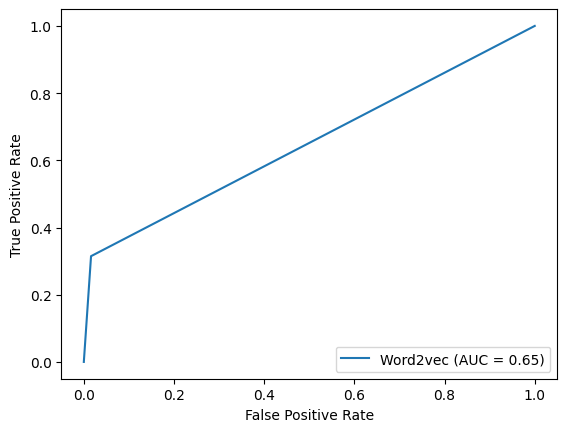

In [43]:
#metrics for the train set
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, matthews_corrcoef, confusion_matrix, precision_recall_curve

trs = y_train[:501]
prevs = predict(model, X_train_np.values[:501], 0.1, verbose1=False, verbose2=False, shouldBe=trs)

#accuracy
accuracy = accuracy_score(trs,prevs)
print('accuracy: {}'.format(accuracy))

#precision, recall, f-score
precision, recall, fscore, support = precision_recall_fscore_support(trs, prevs,average='micro')

#precision - ratio tp / (tp + fp) - ability not to label a negative sample as positive
print('precision: {}'.format(precision))

#recall - ratio tp / (tp + fn) - ability to find all the positive samples - best is 1, worst is 0
print('recall: {}'.format(recall))

#fscore - weighted harmonic mean of the precision and recall - best is 1, worst is 0
print('fscore: {}'.format(fscore))

#matthews correlation coefficient - measure of the quality of binary classifications
#can be used even if the classes are of very different sizes - is in essence a correlation coefficient between -1 and +1
#+1 means perfect prediction, 0 an average random prediction, -1 an inverse prediction
mcc = matthews_corrcoef(trs, prevs)
print('mcc: {}'.format(mcc))

#g-mean - squared root of the product of the sensitivity and specificity - best is 1, worst is 0
print('G-mean:', (geometric_mean_score(trs, prevs,average='micro')))

#specificity - ability to predict true negatives of each available category - recall of the negative class
#specifity = tn / (tn + fp)
#print('specifity: {}'.format(specifity))

#sensitivity - ability to predict true positives of each available category = recall

#confusion matrix    
print(confusion_matrix(trs, prevs))

#true positives, false positives, true negatives, false negatives
tn, fp, fn, tp = confusion_matrix(trs,prevs).ravel()

#true negatives
print('true negatives: {}'.format(tn))

#false positives
print('false positives: {}'.format(fp))

#false negatives
print('false negatives: {}'.format(fn))

#false positives
print('true positives: {}'.format(tp))

#error rate
error_rate = 1 - accuracy
print('error rate: {}'.format(error_rate))

#precision-recall curve - compute precision-recall pairs for different probability thresholds
print(precision_recall_curve(trs, prevs))

#roc curve
import matplotlib.pyplot as plt
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(trs,prevs)

roc_auc = metrics.auc(fpr, tpr)

display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Word2vec')
display.plot()
plt.show()

In [ ]:
#grid-search
#save results
import sys
old_stdout = sys.stdout
log_file = open("results.log", "w")
sys.stdout = log_file

#create a hyperparameters dictionary 
dim = [2, 5, 35, 50, 100, 300]  
cycles = [5, 10, 15, 20, 50] #stop if loss does not decrease
window = range(1, 9, 1)  
negative = range(0, 5, 20, 5) 
exponent =  [-1, -0.75, 0, 0.75, 1] 
alpha = range(0.015, 0.1, 0.005)
min_alpha = range(0.00001, 0.001, 0.0001)
hs = [0, 1]
sample = range(0, 0.00001, 0.00001) 
threshold = range(1e-5, 1e-4, 1e-5)

#train the model 
#for a,b,c in itertools.combination(cycles, dim...)
for c in cycles:
    for d in dim:
        for w in window:
            for n in negative:
                for e in exponent:
                    for a in alpha:
                        for m in min_alpha:
                            for s in sample:
                                for h in hs:
                                    curr_model = training(sentences_series, cycles = c, dim = d, window = w, sample = s, 
                                                        negative = n, hs = h, exponent = e, alpha = a, min_alpha = m)
                                
                                    #metrics for each combination 
                                    predict(curr_model, sentences_series_np_train, 3e-5, verbose1 = False, verbose2 = False)

#save results 
sys.stdout = old_stdout
log_file.close()

In [ ]:
#option 1
#python 3transfers_word2vec_matrix_originalcols_saving.py &> results.txt


#option 2
#def fprint(output):
#    print output
#    with open("somefile.txt", "a") as f:
#        f.write("{}\n".format(output))


#option 3
#from contextlib import redirect_stdout

#with open('results.log', 'w') as f:
#    with redirect_stdout(f):
#        print('generating')
#        # the rest of your code or main function goes here

In [ ]:
#apply the prediction method for the test set
predict(model, X_test_np[:1000], 0.5, verbose1=True, verbose2=True)

In [42]:
#convert true values in train set to binary
y_test = [1 if elem == "fraud" else 0 for elem in y_test]

In [30]:
#true values
set(y_test)

{0, 1}

Transaction Nº 1 	 Sum: 0.9486559238284826 

Transaction Nº 2 	 Sum: 0.9930584088506293 

Transaction Nº 3 	 Sum: 0.9449330735951662 

Transaction Nº 4 	 Sum: 0.950633704662323 

Transaction Nº 5 	 Sum: 0.9458417841864275 

Transaction Nº 6 	 Sum: 0.9431496001780033 

Transaction Nº 7 	 Sum: 0.9677550280837295 

Transaction Nº 8 	 Sum: 0.9982427338836715 

Transaction Nº 9 	 Sum: 0.9708717485636953 

Transaction Nº 10 	 Sum: 0.9385184030979872 

accuracy: 0.4
precision: 0.4
recall: 0.4
fscore: 0.4000000000000001
mcc: 0.0
G-mean: 0.4
specifity: 0.0
[[0 6]
 [0 4]]
true negatives: 0
false positives: 6
false negatives: 0
true positives: 4
error rate: 0.6
(array([0.4, 1. ]), array([1., 0.]), array([1]))


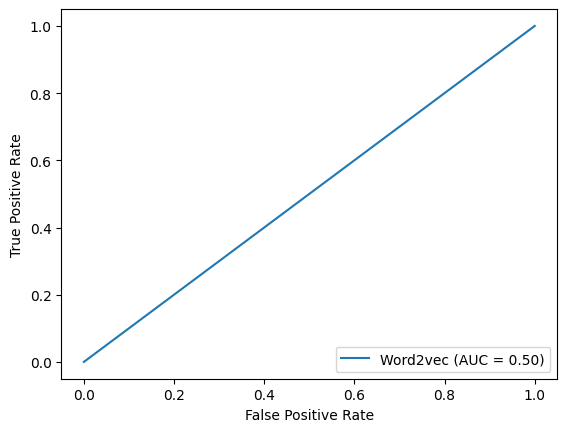

In [52]:
#metrics for the test set 
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, matthews_corrcoef

trs = y_test[:10]
prevs = predict(model, X_test_np.values[:10], 0.1, verbose1=False, verbose2=True, shouldBe=trs)

#accuracy
accuracy = accuracy_score(trs, prevs)
print('accuracy: {}'.format(accuracy))

#precision, recall, f-score
precision, recall, fscore, support = precision_recall_fscore_support(trs,prevs, average='micro')

#precision - ratio tp / (tp + fp) - ability not to label a negative sample as positive
print('precision: {}'.format(precision))

#recall - ratio tp / (tp + fn) - ability to find all the positive samples - best is 1, worst is 0
print('recall: {}'.format(recall))

#fscore - weighted harmonic mean of the precision and recall - best is 1, worst is 0
print('fscore: {}'.format(fscore))

#matthews correlation coefficient - measure of the quality of binary classifications
#can be used even if the classes are of very different sizes - is in essence a correlation coefficient between -1 and +1
#+1 means perfect prediction, 0 an average random prediction, -1 an inverse prediction
mcc = matthews_corrcoef(trs, prevs)
print('mcc: {}'.format(mcc))

#g-mean - squared root of the product of the sensitivity and specificity - best is 1, worst is 0
print('G-mean:', (
    geometric_mean_score(trs, prevs, average='micro')))

#specificity - ability to predict true negatives of each available category - recall of the negative class
specifity = tn / (tn + fp)
print('specifity: {}'.format(specifity))

#sensitivity - ability to predict true positives of each available category = recall

#confusion matrix    
print(confusion_matrix(trs, prevs))

#true positives, false positives, true negatives, false negatives
tn, fp, fn, tp = confusion_matrix(trs, prevs).ravel()

#true negatives
print('true negatives: {}'.format(tn))

#false positives
print('false positives: {}'.format(fp))

#false negatives
print('false negatives: {}'.format(fn))

#false positives
print('true positives: {}'.format(tp))

#error rate
error_rate = 1 - accuracy
print('error rate: {}'.format(error_rate))

#precision-recall curve - compute precision-recall pairs for different probability thresholds
print(precision_recall_curve(trs, prevs))

#roc curve
import matplotlib.pyplot as plt
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(trs, prevs)

roc_auc = metrics.auc(fpr, tpr)

display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Word2vec')
display.plot()
plt.show()

In [ ]:
#save the threshold and the ratio in a list
def thres_numberf():
    threshold = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    ratio = []

    for thresh in threshold:
        #assign to a current variable the prediction result
        curr = predict(model, X_test_np.values, thresh, verbose1=False, verbose2=False)

        #ratio of the number of detected frauds per the number of real frauds
        ratio.append(sum(curr) / sum(y_test))

    return threshold, ratio

In [ ]:
#plot the threshold vs ratio (number of detected frauds/number of real frauds)
import matplotlib.pyplot as plt

#assign the values to plot
thresh, goal = thres_numberf()

plt.plot(thresh, goal, 'b-')
plt.xlabel('threshold')
plt.ylabel('#frauds detected/#real frauds')

#save to csv
thresh_ratio = np.column_stack((thresh.flatten(), goal.flatten()))
np.savetxt('threshold_ratio.csv', thresh_ratio, goal, delimiter=',')

#log scale
plt.yscale('log')

plt.show()

#plt.savefig()

In [ ]:
#---------------------------------------------------density matrix------------------------------------------------------------#

#product of the matrices
mproduct = np.matmul(m1, m2.T)
mproduct.shape

In [ ]:
#apply softmax to obtain a matrix with conditional probabilities
conditional_probs = softmax(mproduct)

In [ ]:
#save density matrix 

#option 1
#np.savetxt('3transfers_word2vec_matrix_originalcols_density_matrix.csv', conditional_probs, delimiter = ',')

#option 2
#pd.DataFrame(conditional_probs).to_csv("3transfers_word2vec_matrix_originalcols_density_matrix.csv", header = None)

In [ ]:
#confirm that softmax sum is 1
conditional_probs.sum()

In [ ]:
#maximum value of the conditional probabilities
np.max(conditional_probs)

In [ ]:
#minimum value of the conditional probabilities
np.min(conditional_probs)

In [ ]:
#visualize the 1st 10 lines and the last 10 lines of the density matrix

#1st 10 lines
conditional_aux = conditional_probs[:10].copy()

#last 10 lines
conditional_aux = np.concatenate((conditional_aux, conditional_probs[-10:].copy()))

#display setting
from IPython.core.display import HTML

display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [ ]:
#shape of the compressed density matrix 
conditional_aux.shape

In [ ]:
#print the compressed conditional probabilities matrix
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in conditional_aux]))

In [ ]:
#-------------------------------------------------eigenvalues-----------------------------------------------------------------#

#eingenvalues of the square matrix before softmax (w has the eigenvalues and v the eigenvectors)
w, v = np.linalg.eig(mproduct)  #mproduct is an array of arrays

#separate real and imaginary parts of the eigenvalues
x = w.real  #array

y = w.imag  #array

In [ ]:
#eigenvalues
w

In [ ]:
#eigenvalues plot for the several vector sizes - square of the numbers in mproduct (product of the matrices before softmax)  
import matplotlib.pyplot as plt


#plot complex numbers
def plot_eigenvalues(model, vec_size):
    x_r = np.square(x)
    y_i = np.square(y)

    plt.plot(x_r, 'b-')
    plt.ylabel('Imaginary')
    plt.xlabel('Real')

    #plt.ylim(0, 250e6)
    #plt.xlim(0, 15)

    fig_name = "vec_size_" + vec_size + "_best_comb.png"
    plt.savefig(fig_name)

    return x_r

In [ ]:
#train the model with the optimized parameters for different vector sizes  

#dictionary of results
result_dic = {}

#vector sizes to try
vec_sizes = [3, 4]

#train the model
for curr_vec in vec_sizes:
    curr_model = w2v.Word2Vec(
        sg=1,  #skip-gram
        workers=multiprocessing.cpu_count(),  #use all cores
        vector_size=curr_vec,  #dimension of the embedding space
        window=9,  #words befores and after the center word
        sample=0,  #whithout subsampling
        min_count=1,  #use every word
        negative=5,  #noise-words
        hs=0,  #negative sampling
        ns_exponent=0,  #exponent to shape negative sampling
        alpha=0.025,  #initial learning rate
        min_alpha=0.0001  #final learning rate
    )

    #vocabulary creation
    model.build_vocab(sentences_series)

    #model training
    model.train(sentences_series, epochs=5, total_examples=model.corpus_count, compute_loss=True,
                callbacks=[callback()])

    #save results in the dictionary 
    result_dic[curr_vec_size] = plot_eigenvalues(curr_model, curr_vec)

In [ ]:
#option 1 - export result_dic and plot in excel
#convert the dictionary to dataframe
result_dic = pd.DataFrame(data=result_dic, index=[0])
result_dic = (result_dic.T)
result_dic.to_excel('3transfers_word2vec_matrix_originalcols_eingenvalues.xlsx')

#option 2 - plot result_dic with matplotlib
plt.plot(list(result_dic.keys()), list(result_dic.values()))
plt.legend(['3', '4'], loc='upper left')
plt.savefig('3transfers_word2vec_matrix_originalcols_eingenvalues.png')